In [1]:
# standard imports
import datetime
import os
import sys

from subprocess import check_output

# third party imports
import matplotlib.pyplot as plt # MATLAB like plotting framework
import numpy as np # linear algebra
import pandas as pd # Data ETL, csv file I/O
import sklearn.metrics as skm

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

# src directory imports
module_path = os.path.abspath(os.path.join('src'))
if module_path not in sys.path:
    sys.path.append(module_path)

from src.helper_functions import load_dataset, plot_roc, plot_confusion_matrix, CleanTextTransformer

%matplotlib inline
pd.options.mode.chained_assignment = None  # default='warn'

In this exercise I will begin to model the likelihood of being a staff_pick for a given campaign. I will start with a tradiitional logistic regression model and examine the feature space using the coefficients. Accuracy will be assessed using the scoring function provided by the sklearn module for each model. For binary classification problems such as what we have here, this will be accuracy. The other metrics I will use are Area under the curve (AUC) and the confusion matrix to examine true/false positive/negative rates.

To begin we load the dataset:

In [2]:
df = load_dataset()

In [3]:
df.staff_pick.value_counts()

False    151234
True      21599
Name: staff_pick, dtype: int64

In [27]:
df['success'] = (df['state'] == 'successful') # notice how I didn't convert to integer. This is not our target variable
test_live = df[df.state == 'live']
df_all = df[df['state'].isin(['successful', 'failed'])]

In [28]:
df_all.success.value_counts()

False    82718
True     73810
Name: success, dtype: int64

In [29]:
pd.crosstab(df_all.success, df_all.staff_pick)

staff_pick,False,True
success,,
False,79279,3439
True,56314,17496


In [30]:
df_all.staff_pick.value_counts()

False    135593
True      20935
Name: staff_pick, dtype: int64

We also need to convert staff pick to integer value.

In [33]:
df['staff_pick'] = df_all.staff_pick.astype(int)

The classes here are heavily imbalanced. To properly perform analysis of a datset like this, we will want to use stratified sampling in our train_test_split step. Drop _id_ and other columns not useful in predicting the response variable at campaign creation time.

In [34]:
df_all.drop(['id', 'backers_count', 'pledged', 'usd_pledged'], axis = 1, inplace = True)

From EDA we figured out we wanted to convert unix time series to a datetime series. I will ignore the state_changed_at column and backers count column since this would not be available during campaign creation.

In [35]:
df_all['launched_at'] = pd.to_datetime(df_all['launched_at'],unit='s')
df_all['state_changed_at'] = pd.to_datetime(df_all['state_changed_at'],unit='s')
df_all['created_at'] = pd.to_datetime(df_all['created_at'],unit='s')
df_all['deadline'] = pd.to_datetime(df_all['deadline'],unit='s')

Since we aren't interested in a longitudinal model at this time and are working with panel data, we will not be using these dateime features in the models. Instead we will use the difference in these datetime columns as continuous numeric values. 

In [36]:
df_all['launched-created'] = (df_all.launched_at - df_all.created_at).dt.components.days
df_all['deadline-launched'] = (df_all.deadline - df_all.launched_at).dt.components.days

In [37]:
datetime_columns = ['launched_at', 'created_at', 'deadline', 'state_changed_at']

In [41]:
baseline_features = df_all.describe().columns
baseline_features = baseline_features.tolist()
baseline_features = baseline_features[:]
# del baseline_features[baseline_features.index('staff_pick')]
baseline_features

['goal', 'static_usd_rate', 'launched-created', 'deadline-launched']

In [42]:
X = df_all.loc[:, baseline_features]
y = df_all.staff_pick.astype('float')

In [43]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=67, stratify=y)

## First Model: Logistic Regression

In [44]:
lr = LogisticRegression(class_weight='balanced')
lr.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [45]:
lr.score(X_test,y_test)

0.75257139206541879

In [46]:
v_probs = lr.predict_proba(X_test)[:, 1]

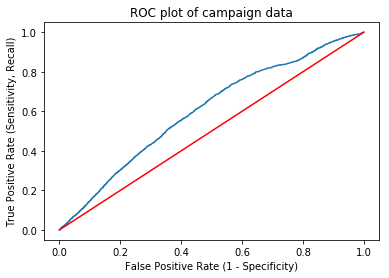

In [47]:
plot_roc(v_probs, y_test, "ROC plot of campaign data", 
         "False Positive Rate (1 - Specificity)", "True Positive Rate (Sensitivity, Recall)")

In [48]:
skm.roc_auc_score(y_test, lr.predict(X_test))

0.54616664306269036

In [49]:
pd.crosstab(y_test, lr.predict(X_test))

col_0,0.0,1.0
staff_pick,,
0.0,22453,4666
1.0,3080,1107


[[22453  4666]
 [ 3080  1107]]


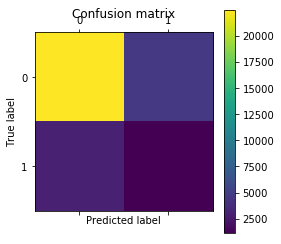

In [50]:
plot_confusion_matrix(lr, X_test, y_test)

This model looks a little better based on the accuracy score of .75 but the area under the curve is pretty terrible. Area under the curve looks at all possible threshold values. Accuracy is just based on a single threshold value of .5. It is a pretty poor metric of classifications model performance. and one of the least important to determining positive predicitive power.

## Conclusion

Under the time constraints (~10h) I can't progress further. The above just described the beginning of modeling the relationship between probability of a campaign being a staff pick and the campaign attributes determined at launch. I just took a peak and I hope you can see where we can go from here. I plan to improve the model by using cross validation or grid searching to select hyperparameters for each model. If we wanted to we could also take a look at stacking models of the textual information, profile information of the campaign creator and possibly web scraped data about the domains.